# 3.3 循环神经网络
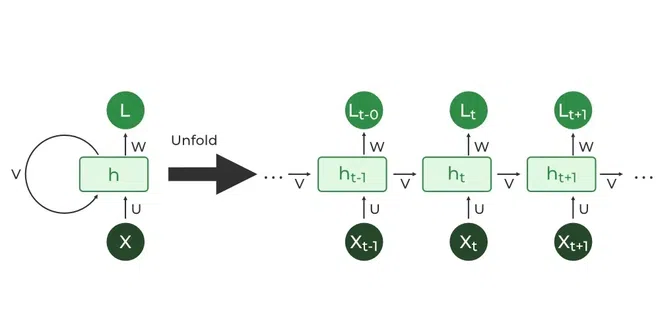

RNN是一种具有循环连接的网络，可以处理任意长度的序列数据。在处理序列的每个时间步时，RNN都会更新其隐藏状态，该隐藏状态是对之前信息的记忆。这节课，我们将使用我们的Tensor类实现一个简单的RNN神经网络

In [ ]:
import sys
sys.path.append('.')

In [ ]:
import numpy as np
import mytorch
from mytorch import Tensor, nn
import mytorch.nn.functional as F

首先我们实现cat函数，这个函数是实现将多个矩阵拼接在一起，当然梯度也按照拼接方式进行分割

In [ ]:
def cat(tensors, dim=0):
        assert all(isinstance(t, Tensor) for t in tensors), "所有输入必须是Tensor对象"
        data = [t.data for t in tensors]
        concatenated_data = np.concatenate(data, axis=dim)
        
        # 创建一个新的Tensor对象作为cat操作的结果
        out = Tensor(concatenated_data, _prev=tuple(tensors), _op='cat')
        
        def _backward():
            # 分割out.grad并将相应的梯度分配给原始的Tensor对象
            grad_splits = np.split(out.grad, np.cumsum([t.data.shape[dim] for t in tensors[:-1]]), axis=dim)
            for t, grad in zip(tensors, grad_splits):
                t.grad += grad
        
        out._backward = _backward
        return out

我们来测试一下这个cat函数

In [ ]:
a = Tensor([[1,2,3]])
b = Tensor([[4,5,6]])
c = cat((a,b))
c

In [ ]:
a = Tensor([[1,2,3]])
b = Tensor([[4,5,6]])
c = cat((a,b), 1)
c

In [ ]:
a = Tensor([[1,2,3,4]])
b = Tensor([[4,5,6,7]])
c = mytorch.cat((a,b), 1)
print(c)

可以看到我们按照 dim=0 拼接会把两个维度是1✖️3的矩阵变成2✖️3的矩阵，按照 dim=1 拼接会把两个维度是1✖️3的矩阵变成1✖️6的矩阵,现在我们需要把cat()函数放到Tensor类中（当然，在原版的pytorch中是torch.cat()）

现在让我们实现dropout方法，这个方法会在模型训练的时候，随机“丢弃”（即将输出置为0）神经网络中的一部分神经元，以减少模型对特定训练样本的依赖，从而防止过拟合。在测试时，不使用dropout，或者等效地，将所有的神经元都保留并将它们的输出乘以保留概率（即训练时未被丢弃的神经元比例），以保持总体的输出期望不变。

In [ ]:
import numpy as np
mask = np.random.binomial(1, 0.1, size=[1,10]) / 0.1
print(mask)

np.random.binomial()函数会按照一定的比例，随机将一部分数设为1，其余设为0，需要注意的是，在执行drouput算法的时候，我们需要让激活值的期望保持不变，因此会使用一种名为“Inverted Dropout”的技术。下面是解释这个操作的原因：
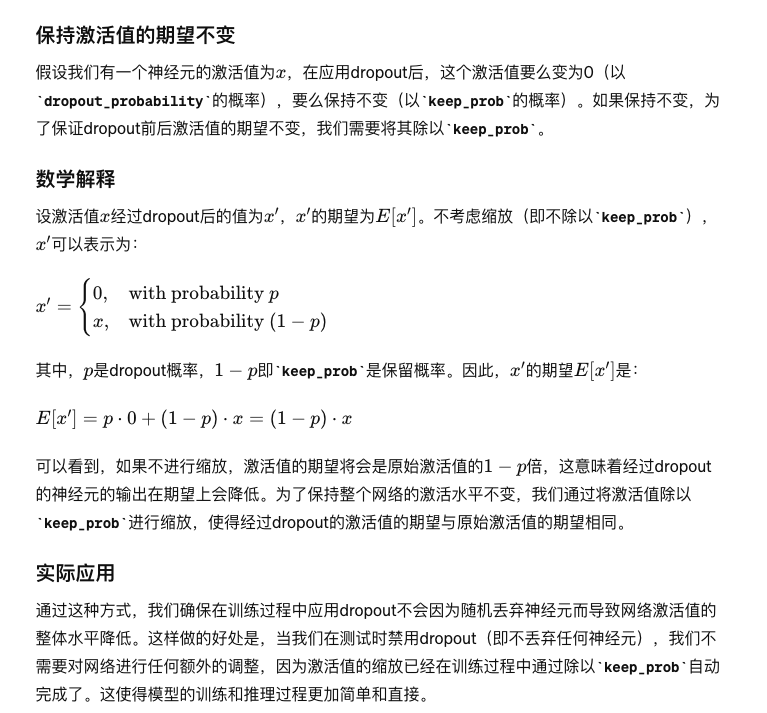

接下来让我们完成完整的drouput函数

In [ ]:
class TempTensor:
    def __init__(self, data, _prev=(), trainable=True, _op='', label=''):
        if not isinstance(data, np.ndarray):
            data = np.array(data, dtype=np.float32)
        self.data = data
        self.grad = np.zeros_like(data, dtype=np.float32)
        self._backward = lambda: None
        self._prev = set(_prev)
        self.trainable = trainable
        self._op = _op
        self.label = label

    def dropout(self, dropout_probability=0.5, is_training=True):
        if not is_training or dropout_probability == 0:
            # 如果不是训练模式或dropout_probability为0，即不丢弃任何元素，直接返回原Tensor
            return self
        else:
            # 在训练模式下，根据1-dropout_probability随机生成dropout掩码
            keep_prob = 1 - dropout_probability
            mask = np.random.binomial(1, keep_prob, size=self.data.shape) / keep_prob
            # 应用dropout掩码
            dropped_out_data = self.data * mask
            
            out = Tensor(dropped_out_data, _prev=(self,), trainable=False, _op='dropout')
            
            def _backward():
                # 反向传播时只对保留下来的元素求导
                self.grad += out.grad * mask
            
            out._backward = _backward
            return out


In [ ]:
a = TempTensor([[1,2,3,4,5,6,7,8,9,10]])
b = a.dropout(0.2)
print(b)

可以看到10个数中，有两个被随机设成了0，其余的被除以了0.8构成了我们现在的结果，现在我们需要把dropout()函数放到Tensor类中

现在让我们实现RNN网络，首先我们定义RNN的构造函数：

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, nonlinearity='tanh', bias=True):
        """
            初始化简单RNN模型。
            参数:
            - input_size: 每个输入项的特征数量。
            - hidden_size: 隐藏层的特征数量。
            - num_layers: RNN的层数，默认为1。
            - nonlinearity: 用于隐藏层的非线性激活函数，默认为'tanh'，可以设置为'relu'。
            - bias: 是否在RNN层中添加偏置项，默认为True。
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.bias = bias
        self.layers = []
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.layers.append(nn.Linear(layer_input_size + hidden_size, hidden_size, bias=bias))
        self.output_layer = nn.Linear(hidden_size, output_size, bias=bias)

In [ ]:
print(F.relu(Tensor([[1,2,3,-1,-2,-3]])))
print(Tensor([[1,2,3,4],[5,6,7,8]]).size(0))
print(mytorch.zeros(Tensor([[1,2,3,4],[5,6,7,8]]).size()))


然后让我们来实现forward函数

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, nonlinearity='tanh', bias=True):
        """
            初始化简单RNN模型。
            参数:
            - input_size: 每个输入项的特征数量。
            - hidden_size: 隐藏层的特征数量。
            - num_layers: RNN的层数，默认为1。
            - nonlinearity: 用于隐藏层的非线性激活函数，默认为'tanh'，可以设置为'relu'。
            - bias: 是否在RNN层中添加偏置项，默认为True。
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.bias = bias
        self.layers = []
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.layers.append(nn.Linear(layer_input_size + hidden_size, hidden_size, bias=bias))
        self.output_layer = nn.Linear(hidden_size, output_size, bias=bias)

    def initHidden(self):
        return mytorch.zeros((1, self.hidden_size))

    def forward(self, input):
        hidden_states = [self.initHidden() for _ in range(self.num_layers)]
        outputs = []
        for t in range(len(input)):
            layer_input = np.expand_dims(input[t], axis=0)
            if not isinstance(layer_input, Tensor):
                layer_input = Tensor(layer_input, trainable=False)
            for i in range(self.num_layers):
                combined = mytorch.cat((layer_input, hidden_states[i]), 1)
                hidden_state = self.layers[i](combined)
                if self.nonlinearity == 'tanh':
                    hidden_state = mytorch.tanh(hidden_state)
                elif self.nonlinearity == 'relu':
                    hidden_state = F.relu(hidden_state)
                layer_input = hidden_state
                hidden_states[i] = hidden_state
            output = self.output_layer(hidden_state)
            outputs.append(output)

        outputs = mytorch.cat(outputs, 0)
        return outputs, hidden_states

    def __repr__(self):
        return f"RNN(input_size={self.input_size}, hidden_size={self.hidden_size}, num_layers={self.num_layers})"

很好，现在让我们来测试这个循环神经网络，首先我们需要创建我们的训练集，我们现在用累加和数据来训练模型，希望模型能学会计算累加和的结果

In [ ]:
import numpy as np

def generate_data(sequence_length, total_samples):
    # 生成随机序列，每个序列现在是6行1列
    inputs = np.random.randint(1, 10, size=(total_samples, sequence_length, 1))
    # 计算累加和，仍然沿着序列长度的维度，但现在每个序列都是一个二维数组
    targets = np.cumsum(inputs, axis=1)
    return inputs, targets

# 设置参数
sequence_length = 6
total_samples = 20

# 生成数据
inputs, targets = generate_data(sequence_length, total_samples)

# 显示前几个样本以验证
for i in range(5):
    print(f"输入序列 {i+1}: {inputs[i]}, 累加和: {targets[i]}")

现在让我们定义我们的训练函数，来实现对这个RNN模型的训练

In [ ]:
model = RNN(input_size=1, hidden_size=10, output_size=1, num_layers=3, nonlinearity='relu')

In [ ]:
model(inputs[0])

In [ ]:
class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        pred = pred.data if isinstance(pred, Tensor) else pred
        target = target.data if isinstance(target, Tensor) else target
        def mse_recursive(p, t):
            if type(p) not in [list, tuple] or type(t) not in [list, tuple]:
                return (p - t) ** 2
            else:
                return sum([mse_recursive(pi, ti) for pi, ti in zip(p, t)]) / len(p)

        total_loss = mse_recursive(pred, target)
        return Tensor(total_loss)

In [ ]:
epoch = 10

# 初始化你的RNN模型
model = RNN(input_size=1, hidden_size=10, output_size=1, num_layers=3, nonlinearity='relu')
mse_loss = MSELoss()
t = 0
# 使用自定义数据集训练模型
for i in range(epoch):
    outputs = [model(input)[0] for input in inputs]
    loss= mse_loss(outputs,targets)
    loss.backward()
    t = loss.adam_opt(t, learning_rate=0.001)
    print(f'Epoch {i}/{epoch}, Loss: {loss}')